In [334]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
os.getcwd()
os.chdir("/home/mbilkis/OneDrive/digital-brain/RESEARCH/Sindy/")
from numerics.utilities.misc import *
import matplotlib.pyplot as plt 



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [335]:
give_params()

([94.24777960769379, 6283.185307179586, 14.0, 1000.0, 2261.946710584651, 0.0],
 '[94.24777960769379, 6283.185307179586, 14.0, 1000.0, 2261.946710584651, 0.0]/')

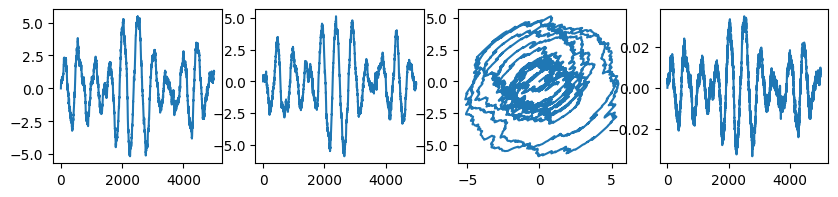

In [336]:
x = load_data(itraj=1, what="hidden_state.npy")
dy = load_data(itraj=1,what="dys.npy")

plt.figure(figsize=(10,2))
ax=plt.subplot(141)
ax.plot(x[:,0])
ax=plt.subplot(142)
ax.plot(x[:,1])
ax=plt.subplot(143)
ax.plot(x[:,0],x[:,1])
ax=plt.subplot(144)
ax.plot(dy[:,0])

In [337]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.linalg import solve_continuous_are


In [338]:
class GRNN(torch.nn.Module):
    def __init__(self,inputs_cell):
        super(GRNN, self).__init__()
        
        self.dt, self.simulation_params, omega_initial = inputs_cell
        gamma, omega, n, eta, kappa, b = self.simulation_params 
        self.omega_p = torch.nn.Parameter(data = torch.tensor([omega_initial],dtype=torch.float32,
                                                              requires_grad=True))
        
        self.proj_C = torch.tensor(data=[[1.,0.],[0.,0.]], dtype=torch.float32).detach()
        self.C = np.sqrt(4*eta*kappa)*self.proj_C.detach()
        self.D = (gamma*(n+0.5) + kappa)*torch.eye(2).detach()
        
    def forward(self, dy, state):
        """
        input_data is dy
        hidden_state is x: (<q>, <p>, Var[x], Var[p], Cov(q,q)})
        output dy_hat
        """
        x = state[:2]
        [vx,vp,cxp] = state[2:]
        cov = torch.tensor(data = [[vx,cxp],[cxp,vp]], dtype=torch.float32)
        
        A = torch.tensor(data = [[0,1],[-1,0]], dtype=torch.float32)*self.omega_p 
        A+= torch.tensor(data = -0.5*gamma*np.eye(2), dtype=torch.float32)
        xicov = cov.matmul(self.C.T)
        
        dx = (A - xicov.matmul(self.C)).matmul(x)*dt + xicov.matmul(dy)
        
        dcov = self.dt*(cov.matmul(A.T) + (A).matmul(cov) + self.D - (xicov.matmul(xicov.T)))
        ncov = cov+dcov
        nstate = torch.concatenate([(x + dx), torch.tensor([ncov[0,0],ncov[1,1],ncov[1,0]])])

        dy_hat = self.C.matmul(x)*self.dt

        return nstate, dy_hat

class RecurrentNetwork(torch.nn.Module):
    def __init__(self,inputs_cell):
        super(RecurrentNetwork, self).__init__()
        self.RCell = GRNN(inputs_cell=inputs_cell)
        self.params = inputs_cell[1]
        
    def forward(self, dys):
        dys_hat = []
        
        ### Find stationary value of covariance for the parameter RCell currently has
        gamma, omega, n, eta, kappa, b = self.params 
        omega_p = self.RCell.omega_p.detach().numpy()[0]
        A = np.array([[-gamma/2, omega_p],[-omega_p, -gamma/2]])
        proj_C = np.array([[1.,0.],[0.,0.]])
        C = np.sqrt(4*eta*kappa)*proj_C
        D = np.diag([gamma*(n+0.5) + kappa]*2)
        G = np.zeros((2,2))
        Cov = solve_continuous_are((A-G.dot(C)).T, C.T, D- (G.T).dot(G), np.eye(2)) #### A.T because the way it's implemented!
        
        xs_hat = [torch.tensor([0., 0., Cov[0,0], Cov[1,1],Cov[1,0]], dtype=torch.float32)]
        x_hat = xs_hat[0]
        for dy_t in dys:
            x_hat, dy_hat = self.RCell(dy_t, x_hat)
            dys_hat += [dy_hat]
            xs_hat += [x_hat]
        return torch.stack(xs_hat), torch.stack(dys_hat)

In [339]:
np.array(params)/kappa

array([1.e-04, 1.e-04, 1.e-03, 1.e-05, 1.e+00, 0.e+00])

In [354]:
params, exp_path = give_params()

####
gamma, omega, n, eta, kappa, b = params
period = (2*np.pi/omega)
total_time = period*10
dt = period/500


gamma, omega, n, eta, kappa, b = params

A = np.array([[-gamma/2, omega],[-omega, -gamma/2]])
proj_C = np.array([[1.,0.],[0.,0.]])
C = np.sqrt(4*eta*kappa)*proj_C
D = np.diag([gamma*(n+0.5) + kappa]*2)
G = np.zeros((2,2))

Cov = solve_continuous_are((A-G.dot(C)).T, C.T, D- (G.T).dot(G), np.eye(2)) #### A.T because the way it's implemented!
XiCov = Cov.dot(C.T) + G.T



In [355]:
omega_initial = 20*omega
inputs_cell = [dt,  [gamma, omega, n, eta, kappa, b], omega_initial]

x = load_data(itraj=1, what="hidden_state.npy")
dy = load_data(itraj=1,what="dys.npy")


In [356]:


dev = torch.device("cpu")
rrn = RecurrentNetwork(inputs_cell)
dys = torch.tensor(data=dy, dtype=torch.float32).to(dev)

In [357]:


xs_hat, dys_hat = rrn(dys)

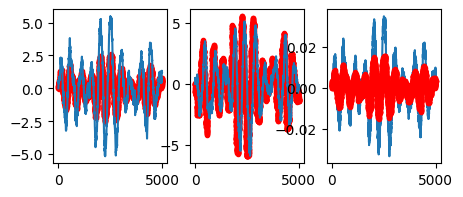

In [358]:
plt.figure(figsize=(5,2))
ax=plt.subplot(131)
ax.plot(xs_hat.detach().numpy()[:,0], color="red",marker='.')
ax.plot(x[:,0])
ax=plt.subplot(132)
ax.plot(xs_hat.detach().numpy()[:,1], color="red",marker='.')
ax.plot(x[:,1])
ax=plt.subplot(133)
ax.plot(dys[:,0])
ax.plot(dys_hat.detach().numpy()[:,0], color="red",marker='.')


# Training

In [359]:
def log_lik(dys, dys_hat):
    return torch.sum((dys-dys_hat)**2)/(dt*len(dys))

In [372]:
omegas_landscape = np.linspace(0.05*omega, 5*omega, 11)

loss_landscape = {}
for o in tqdm(omegas_landscape):

    inputs_cell = [dt,  [gamma, omega, n, eta, kappa, b], o]

    x = load_data(itraj=1, what="hidden_state.npy")
    dy = load_data(itraj=1,what="dys.npy")


    dev = torch.device("cpu")
    rrn = RecurrentNetwork(inputs_cell)
    dys = torch.tensor(data=dy, dtype=torch.float32).to(dev)

    xs_hat, dys_hat = rrn(dys)
    loss_landscape[o] = log_lik(dys, dys_hat)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:20<00:00,  1.85s/it]


Text(0, 0.5, '$L(\\omega)$')

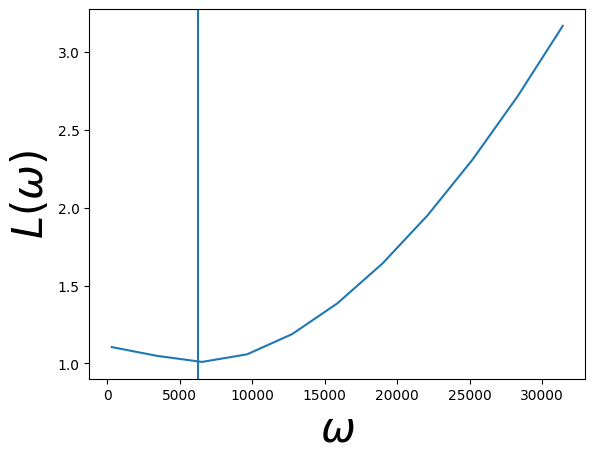

In [375]:
plt.figure()
ax = plt.subplot()
ax.plot(omegas_landscape, torch.stack(list(loss_landscape.values())).detach().numpy())
ax.axvline(omega)
ax.set_xlabel(r'$\omega$',size=30)
ax.set_ylabel(r'$L(\omega)$',size=30)

In [360]:
log_lik(dys,dys_hat)

tensor(28.4895, grad_fn=<DivBackward0>)

In [381]:
inputs_cell = [dt,  [gamma, omega, n, eta, kappa, b], 10*omega]

x = load_data(itraj=1, what="hidden_state.npy")
dy = load_data(itraj=1,what="dys.npy")

dev = torch.device("cpu")
rrn = RecurrentNetwork(inputs_cell)


In [397]:
rrn.RCell.omega_p

Parameter containing:
tensor([10739.9023], requires_grad=True)

In [396]:
list(rrn.parameters())

[Parameter containing:
 tensor([10739.9023], requires_grad=True)]

In [421]:
inputs_cell = [dt,  [gamma, omega, n, eta, kappa, b], 10*omega]

x = load_data(itraj=1, what="hidden_state.npy")
dy = load_data(itraj=1,what="dys.npy")

dev = torch.device("cpu")
rrn = RecurrentNetwork(inputs_cell)


optimizer = torch.optim.Adam(list(rrn.parameters()), lr=1e3)

dys = torch.tensor(data=dy, dtype=torch.float32).to(torch.device("cpu"))

history = {}
history["losses"] = []
history["params"] = []
history["gradients"] = []

for ind in tqdm(range(30)):
    xs_hat, dys_hat = rrn(dys)
    loss = log_lik(dys, dys_hat)
    loss.backward()
    optimizer.step()
    history["losses"].append(loss.item())
    history["params"].append(rrn.RCell.omega_p.detach().numpy()[0])
    history["gradients"].append(rrn.RCell.omega_p.grad.numpy())
    
    print(loss.item())
    
    optimizer.zero_grad()

  3%|███▍                                                                                                    | 1/30 [00:02<01:04,  2.23s/it]

{'losses': [9.83089542388916], 'params': [61831.902], 'gradients': [array([0.00020061], dtype=float32)]}


  7%|██████▉                                                                                                 | 2/30 [00:04<01:06,  2.37s/it]

{'losses': [9.83089542388916, 9.571117401123047], 'params': [61831.902, 60832.1], 'gradients': [array([0.00020061], dtype=float32), array([0.00019949], dtype=float32)]}


 10%|██████████▍                                                                                             | 3/30 [00:07<01:03,  2.36s/it]

{'losses': [9.83089542388916, 9.571117401123047, 9.31385326385498], 'params': [61831.902, 60832.1, 59832.562], 'gradients': [array([0.00020061], dtype=float32), array([0.00019949], dtype=float32), array([0.00019831], dtype=float32)]}


 13%|█████████████▊                                                                                          | 4/30 [00:09<01:01,  2.35s/it]

{'losses': [9.83089542388916, 9.571117401123047, 9.31385326385498, 9.05919075012207], 'params': [61831.902, 60832.1, 59832.562, 58833.406], 'gradients': [array([0.00020061], dtype=float32), array([0.00019949], dtype=float32), array([0.00019831], dtype=float32), array([0.00019708], dtype=float32)]}


 17%|█████████████████▎                                                                                      | 5/30 [00:12<01:02,  2.49s/it]

{'losses': [9.83089542388916, 9.571117401123047, 9.31385326385498, 9.05919075012207, 8.807238578796387], 'params': [61831.902, 60832.1, 59832.562, 58833.406, 57834.76], 'gradients': [array([0.00020061], dtype=float32), array([0.00019949], dtype=float32), array([0.00019831], dtype=float32), array([0.00019708], dtype=float32), array([0.00019579], dtype=float32)]}


 20%|████████████████████▊                                                                                   | 6/30 [00:15<01:04,  2.70s/it]

{'losses': [9.83089542388916, 9.571117401123047, 9.31385326385498, 9.05919075012207, 8.807238578796387, 8.558082580566406], 'params': [61831.902, 60832.1, 59832.562, 58833.406, 57834.76, 56836.766], 'gradients': [array([0.00020061], dtype=float32), array([0.00019949], dtype=float32), array([0.00019831], dtype=float32), array([0.00019708], dtype=float32), array([0.00019579], dtype=float32), array([0.00019444], dtype=float32)]}


 23%|████████████████████████▎                                                                               | 7/30 [00:17<00:59,  2.58s/it]

{'losses': [9.83089542388916, 9.571117401123047, 9.31385326385498, 9.05919075012207, 8.807238578796387, 8.558082580566406, 8.311820983886719], 'params': [61831.902, 60832.1, 59832.562, 58833.406, 57834.76, 56836.766, 55839.562], 'gradients': [array([0.00020061], dtype=float32), array([0.00019949], dtype=float32), array([0.00019831], dtype=float32), array([0.00019708], dtype=float32), array([0.00019579], dtype=float32), array([0.00019444], dtype=float32), array([0.00019303], dtype=float32)]}


 27%|███████████████████████████▋                                                                            | 8/30 [00:19<00:55,  2.52s/it]

{'losses': [9.83089542388916, 9.571117401123047, 9.31385326385498, 9.05919075012207, 8.807238578796387, 8.558082580566406, 8.311820983886719, 8.068558692932129], 'params': [61831.902, 60832.1, 59832.562, 58833.406, 57834.76, 56836.766, 55839.562, 54843.31], 'gradients': [array([0.00020061], dtype=float32), array([0.00019949], dtype=float32), array([0.00019831], dtype=float32), array([0.00019708], dtype=float32), array([0.00019579], dtype=float32), array([0.00019444], dtype=float32), array([0.00019303], dtype=float32), array([0.00019156], dtype=float32)]}


 30%|███████████████████████████████▏                                                                        | 9/30 [00:22<00:53,  2.54s/it]

{'losses': [9.83089542388916, 9.571117401123047, 9.31385326385498, 9.05919075012207, 8.807238578796387, 8.558082580566406, 8.311820983886719, 8.068558692932129, 7.828386306762695], 'params': [61831.902, 60832.1, 59832.562, 58833.406, 57834.76, 56836.766, 55839.562, 54843.31, 53848.17], 'gradients': [array([0.00020061], dtype=float32), array([0.00019949], dtype=float32), array([0.00019831], dtype=float32), array([0.00019708], dtype=float32), array([0.00019579], dtype=float32), array([0.00019444], dtype=float32), array([0.00019303], dtype=float32), array([0.00019156], dtype=float32), array([0.00019003], dtype=float32)]}


 33%|██████████████████████████████████▎                                                                    | 10/30 [00:25<00:53,  2.68s/it]

{'losses': [9.83089542388916, 9.571117401123047, 9.31385326385498, 9.05919075012207, 8.807238578796387, 8.558082580566406, 8.311820983886719, 8.068558692932129, 7.828386306762695, 7.591405391693115], 'params': [61831.902, 60832.1, 59832.562, 58833.406, 57834.76, 56836.766, 55839.562, 54843.31, 53848.17, 52854.324], 'gradients': [array([0.00020061], dtype=float32), array([0.00019949], dtype=float32), array([0.00019831], dtype=float32), array([0.00019708], dtype=float32), array([0.00019579], dtype=float32), array([0.00019444], dtype=float32), array([0.00019303], dtype=float32), array([0.00019156], dtype=float32), array([0.00019003], dtype=float32), array([0.00018845], dtype=float32)]}


 37%|█████████████████████████████████████▊                                                                 | 11/30 [00:28<00:52,  2.74s/it]

{'losses': [9.83089542388916, 9.571117401123047, 9.31385326385498, 9.05919075012207, 8.807238578796387, 8.558082580566406, 8.311820983886719, 8.068558692932129, 7.828386306762695, 7.591405391693115, 7.35771369934082], 'params': [61831.902, 60832.1, 59832.562, 58833.406, 57834.76, 56836.766, 55839.562, 54843.31, 53848.17, 52854.324, 51861.95], 'gradients': [array([0.00020061], dtype=float32), array([0.00019949], dtype=float32), array([0.00019831], dtype=float32), array([0.00019708], dtype=float32), array([0.00019579], dtype=float32), array([0.00019444], dtype=float32), array([0.00019303], dtype=float32), array([0.00019156], dtype=float32), array([0.00019003], dtype=float32), array([0.00018845], dtype=float32), array([0.0001868], dtype=float32)]}


 40%|█████████████████████████████████████████▏                                                             | 12/30 [00:30<00:47,  2.64s/it]

{'losses': [9.83089542388916, 9.571117401123047, 9.31385326385498, 9.05919075012207, 8.807238578796387, 8.558082580566406, 8.311820983886719, 8.068558692932129, 7.828386306762695, 7.591405391693115, 7.35771369934082, 7.127407073974609], 'params': [61831.902, 60832.1, 59832.562, 58833.406, 57834.76, 56836.766, 55839.562, 54843.31, 53848.17, 52854.324, 51861.95, 50871.24], 'gradients': [array([0.00020061], dtype=float32), array([0.00019949], dtype=float32), array([0.00019831], dtype=float32), array([0.00019708], dtype=float32), array([0.00019579], dtype=float32), array([0.00019444], dtype=float32), array([0.00019303], dtype=float32), array([0.00019156], dtype=float32), array([0.00019003], dtype=float32), array([0.00018845], dtype=float32), array([0.0001868], dtype=float32), array([0.00018509], dtype=float32)]}


 43%|████████████████████████████████████████████▋                                                          | 13/30 [00:33<00:44,  2.59s/it]

{'losses': [9.83089542388916, 9.571117401123047, 9.31385326385498, 9.05919075012207, 8.807238578796387, 8.558082580566406, 8.311820983886719, 8.068558692932129, 7.828386306762695, 7.591405391693115, 7.35771369934082, 7.127407073974609, 6.900579929351807], 'params': [61831.902, 60832.1, 59832.562, 58833.406, 57834.76, 56836.766, 55839.562, 54843.31, 53848.17, 52854.324, 51861.95, 50871.24, 49882.395], 'gradients': [array([0.00020061], dtype=float32), array([0.00019949], dtype=float32), array([0.00019831], dtype=float32), array([0.00019708], dtype=float32), array([0.00019579], dtype=float32), array([0.00019444], dtype=float32), array([0.00019303], dtype=float32), array([0.00019156], dtype=float32), array([0.00019003], dtype=float32), array([0.00018845], dtype=float32), array([0.0001868], dtype=float32), array([0.00018509], dtype=float32), array([0.00018333], dtype=float32)]}


 47%|████████████████████████████████████████████████                                                       | 14/30 [00:35<00:40,  2.55s/it]

{'losses': [9.83089542388916, 9.571117401123047, 9.31385326385498, 9.05919075012207, 8.807238578796387, 8.558082580566406, 8.311820983886719, 8.068558692932129, 7.828386306762695, 7.591405391693115, 7.35771369934082, 7.127407073974609, 6.900579929351807, 6.677331447601318], 'params': [61831.902, 60832.1, 59832.562, 58833.406, 57834.76, 56836.766, 55839.562, 54843.31, 53848.17, 52854.324, 51861.95, 50871.24, 49882.395, 48895.625], 'gradients': [array([0.00020061], dtype=float32), array([0.00019949], dtype=float32), array([0.00019831], dtype=float32), array([0.00019708], dtype=float32), array([0.00019579], dtype=float32), array([0.00019444], dtype=float32), array([0.00019303], dtype=float32), array([0.00019156], dtype=float32), array([0.00019003], dtype=float32), array([0.00018845], dtype=float32), array([0.0001868], dtype=float32), array([0.00018509], dtype=float32), array([0.00018333], dtype=float32), array([0.0001815], dtype=float32)]}


 50%|███████████████████████████████████████████████████▌                                                   | 15/30 [00:38<00:39,  2.61s/it]

{'losses': [9.83089542388916, 9.571117401123047, 9.31385326385498, 9.05919075012207, 8.807238578796387, 8.558082580566406, 8.311820983886719, 8.068558692932129, 7.828386306762695, 7.591405391693115, 7.35771369934082, 7.127407073974609, 6.900579929351807, 6.677331447601318, 6.457752704620361], 'params': [61831.902, 60832.1, 59832.562, 58833.406, 57834.76, 56836.766, 55839.562, 54843.31, 53848.17, 52854.324, 51861.95, 50871.24, 49882.395, 48895.625, 47911.152], 'gradients': [array([0.00020061], dtype=float32), array([0.00019949], dtype=float32), array([0.00019831], dtype=float32), array([0.00019708], dtype=float32), array([0.00019579], dtype=float32), array([0.00019444], dtype=float32), array([0.00019303], dtype=float32), array([0.00019156], dtype=float32), array([0.00019003], dtype=float32), array([0.00018845], dtype=float32), array([0.0001868], dtype=float32), array([0.00018509], dtype=float32), array([0.00018333], dtype=float32), array([0.0001815], dtype=float32), array([0.00017961], 

 53%|██████████████████████████████████████████████████████▉                                                | 16/30 [00:41<00:36,  2.60s/it]

{'losses': [9.83089542388916, 9.571117401123047, 9.31385326385498, 9.05919075012207, 8.807238578796387, 8.558082580566406, 8.311820983886719, 8.068558692932129, 7.828386306762695, 7.591405391693115, 7.35771369934082, 7.127407073974609, 6.900579929351807, 6.677331447601318, 6.457752704620361, 6.241939544677734], 'params': [61831.902, 60832.1, 59832.562, 58833.406, 57834.76, 56836.766, 55839.562, 54843.31, 53848.17, 52854.324, 51861.95, 50871.24, 49882.395, 48895.625, 47911.152, 46929.203], 'gradients': [array([0.00020061], dtype=float32), array([0.00019949], dtype=float32), array([0.00019831], dtype=float32), array([0.00019708], dtype=float32), array([0.00019579], dtype=float32), array([0.00019444], dtype=float32), array([0.00019303], dtype=float32), array([0.00019156], dtype=float32), array([0.00019003], dtype=float32), array([0.00018845], dtype=float32), array([0.0001868], dtype=float32), array([0.00018509], dtype=float32), array([0.00018333], dtype=float32), array([0.0001815], dtype=

 57%|██████████████████████████████████████████████████████████▎                                            | 17/30 [00:43<00:34,  2.65s/it]

{'losses': [9.83089542388916, 9.571117401123047, 9.31385326385498, 9.05919075012207, 8.807238578796387, 8.558082580566406, 8.311820983886719, 8.068558692932129, 7.828386306762695, 7.591405391693115, 7.35771369934082, 7.127407073974609, 6.900579929351807, 6.677331447601318, 6.457752704620361, 6.241939544677734, 6.02997350692749], 'params': [61831.902, 60832.1, 59832.562, 58833.406, 57834.76, 56836.766, 55839.562, 54843.31, 53848.17, 52854.324, 51861.95, 50871.24, 49882.395, 48895.625, 47911.152, 46929.203, 45950.016], 'gradients': [array([0.00020061], dtype=float32), array([0.00019949], dtype=float32), array([0.00019831], dtype=float32), array([0.00019708], dtype=float32), array([0.00019579], dtype=float32), array([0.00019444], dtype=float32), array([0.00019303], dtype=float32), array([0.00019156], dtype=float32), array([0.00019003], dtype=float32), array([0.00018845], dtype=float32), array([0.0001868], dtype=float32), array([0.00018509], dtype=float32), array([0.00018333], dtype=float3

 60%|█████████████████████████████████████████████████████████████▊                                         | 18/30 [00:46<00:31,  2.60s/it]

{'losses': [9.83089542388916, 9.571117401123047, 9.31385326385498, 9.05919075012207, 8.807238578796387, 8.558082580566406, 8.311820983886719, 8.068558692932129, 7.828386306762695, 7.591405391693115, 7.35771369934082, 7.127407073974609, 6.900579929351807, 6.677331447601318, 6.457752704620361, 6.241939544677734, 6.02997350692749, 5.821946620941162], 'params': [61831.902, 60832.1, 59832.562, 58833.406, 57834.76, 56836.766, 55839.562, 54843.31, 53848.17, 52854.324, 51861.95, 50871.24, 49882.395, 48895.625, 47911.152, 46929.203, 45950.016, 44973.836], 'gradients': [array([0.00020061], dtype=float32), array([0.00019949], dtype=float32), array([0.00019831], dtype=float32), array([0.00019708], dtype=float32), array([0.00019579], dtype=float32), array([0.00019444], dtype=float32), array([0.00019303], dtype=float32), array([0.00019156], dtype=float32), array([0.00019003], dtype=float32), array([0.00018845], dtype=float32), array([0.0001868], dtype=float32), array([0.00018509], dtype=float32), ar

 63%|█████████████████████████████████████████████████████████████████▏                                     | 19/30 [00:48<00:28,  2.55s/it]

{'losses': [9.83089542388916, 9.571117401123047, 9.31385326385498, 9.05919075012207, 8.807238578796387, 8.558082580566406, 8.311820983886719, 8.068558692932129, 7.828386306762695, 7.591405391693115, 7.35771369934082, 7.127407073974609, 6.900579929351807, 6.677331447601318, 6.457752704620361, 6.241939544677734, 6.02997350692749, 5.821946620941162, 5.617944717407227], 'params': [61831.902, 60832.1, 59832.562, 58833.406, 57834.76, 56836.766, 55839.562, 54843.31, 53848.17, 52854.324, 51861.95, 50871.24, 49882.395, 48895.625, 47911.152, 46929.203, 45950.016, 44973.836, 44000.918], 'gradients': [array([0.00020061], dtype=float32), array([0.00019949], dtype=float32), array([0.00019831], dtype=float32), array([0.00019708], dtype=float32), array([0.00019579], dtype=float32), array([0.00019444], dtype=float32), array([0.00019303], dtype=float32), array([0.00019156], dtype=float32), array([0.00019003], dtype=float32), array([0.00018845], dtype=float32), array([0.0001868], dtype=float32), array([0

 67%|████████████████████████████████████████████████████████████████████▋                                  | 20/30 [00:51<00:24,  2.48s/it]

{'losses': [9.83089542388916, 9.571117401123047, 9.31385326385498, 9.05919075012207, 8.807238578796387, 8.558082580566406, 8.311820983886719, 8.068558692932129, 7.828386306762695, 7.591405391693115, 7.35771369934082, 7.127407073974609, 6.900579929351807, 6.677331447601318, 6.457752704620361, 6.241939544677734, 6.02997350692749, 5.821946620941162, 5.617944717407227, 5.41805362701416], 'params': [61831.902, 60832.1, 59832.562, 58833.406, 57834.76, 56836.766, 55839.562, 54843.31, 53848.17, 52854.324, 51861.95, 50871.24, 49882.395, 48895.625, 47911.152, 46929.203, 45950.016, 44973.836, 44000.918, 43031.523], 'gradients': [array([0.00020061], dtype=float32), array([0.00019949], dtype=float32), array([0.00019831], dtype=float32), array([0.00019708], dtype=float32), array([0.00019579], dtype=float32), array([0.00019444], dtype=float32), array([0.00019303], dtype=float32), array([0.00019156], dtype=float32), array([0.00019003], dtype=float32), array([0.00018845], dtype=float32), array([0.00018

 70%|████████████████████████████████████████████████████████████████████████                               | 21/30 [00:53<00:22,  2.47s/it]

{'losses': [9.83089542388916, 9.571117401123047, 9.31385326385498, 9.05919075012207, 8.807238578796387, 8.558082580566406, 8.311820983886719, 8.068558692932129, 7.828386306762695, 7.591405391693115, 7.35771369934082, 7.127407073974609, 6.900579929351807, 6.677331447601318, 6.457752704620361, 6.241939544677734, 6.02997350692749, 5.821946620941162, 5.617944717407227, 5.41805362701416, 5.222340106964111], 'params': [61831.902, 60832.1, 59832.562, 58833.406, 57834.76, 56836.766, 55839.562, 54843.31, 53848.17, 52854.324, 51861.95, 50871.24, 49882.395, 48895.625, 47911.152, 46929.203, 45950.016, 44973.836, 44000.918, 43031.523, 42065.926], 'gradients': [array([0.00020061], dtype=float32), array([0.00019949], dtype=float32), array([0.00019831], dtype=float32), array([0.00019708], dtype=float32), array([0.00019579], dtype=float32), array([0.00019444], dtype=float32), array([0.00019303], dtype=float32), array([0.00019156], dtype=float32), array([0.00019003], dtype=float32), array([0.00018845], 

 73%|███████████████████████████████████████████████████████████████████████████▌                           | 22/30 [00:55<00:19,  2.47s/it]

{'losses': [9.83089542388916, 9.571117401123047, 9.31385326385498, 9.05919075012207, 8.807238578796387, 8.558082580566406, 8.311820983886719, 8.068558692932129, 7.828386306762695, 7.591405391693115, 7.35771369934082, 7.127407073974609, 6.900579929351807, 6.677331447601318, 6.457752704620361, 6.241939544677734, 6.02997350692749, 5.821946620941162, 5.617944717407227, 5.41805362701416, 5.222340106964111, 5.03088903427124], 'params': [61831.902, 60832.1, 59832.562, 58833.406, 57834.76, 56836.766, 55839.562, 54843.31, 53848.17, 52854.324, 51861.95, 50871.24, 49882.395, 48895.625, 47911.152, 46929.203, 45950.016, 44973.836, 44000.918, 43031.523, 42065.926, 41104.402], 'gradients': [array([0.00020061], dtype=float32), array([0.00019949], dtype=float32), array([0.00019831], dtype=float32), array([0.00019708], dtype=float32), array([0.00019579], dtype=float32), array([0.00019444], dtype=float32), array([0.00019303], dtype=float32), array([0.00019156], dtype=float32), array([0.00019003], dtype=f

 77%|██████████████████████████████████████████████████████████████████████████████▉                        | 23/30 [00:58<00:17,  2.48s/it]

{'losses': [9.83089542388916, 9.571117401123047, 9.31385326385498, 9.05919075012207, 8.807238578796387, 8.558082580566406, 8.311820983886719, 8.068558692932129, 7.828386306762695, 7.591405391693115, 7.35771369934082, 7.127407073974609, 6.900579929351807, 6.677331447601318, 6.457752704620361, 6.241939544677734, 6.02997350692749, 5.821946620941162, 5.617944717407227, 5.41805362701416, 5.222340106964111, 5.03088903427124, 4.843766212463379], 'params': [61831.902, 60832.1, 59832.562, 58833.406, 57834.76, 56836.766, 55839.562, 54843.31, 53848.17, 52854.324, 51861.95, 50871.24, 49882.395, 48895.625, 47911.152, 46929.203, 45950.016, 44973.836, 44000.918, 43031.523, 42065.926, 41104.402, 40147.242], 'gradients': [array([0.00020061], dtype=float32), array([0.00019949], dtype=float32), array([0.00019831], dtype=float32), array([0.00019708], dtype=float32), array([0.00019579], dtype=float32), array([0.00019444], dtype=float32), array([0.00019303], dtype=float32), array([0.00019156], dtype=float32

 80%|██████████████████████████████████████████████████████████████████████████████████▍                    | 24/30 [01:00<00:14,  2.47s/it]

{'losses': [9.83089542388916, 9.571117401123047, 9.31385326385498, 9.05919075012207, 8.807238578796387, 8.558082580566406, 8.311820983886719, 8.068558692932129, 7.828386306762695, 7.591405391693115, 7.35771369934082, 7.127407073974609, 6.900579929351807, 6.677331447601318, 6.457752704620361, 6.241939544677734, 6.02997350692749, 5.821946620941162, 5.617944717407227, 5.41805362701416, 5.222340106964111, 5.03088903427124, 4.843766212463379, 4.661043167114258], 'params': [61831.902, 60832.1, 59832.562, 58833.406, 57834.76, 56836.766, 55839.562, 54843.31, 53848.17, 52854.324, 51861.95, 50871.24, 49882.395, 48895.625, 47911.152, 46929.203, 45950.016, 44973.836, 44000.918, 43031.523, 42065.926, 41104.402, 40147.242, 39194.742], 'gradients': [array([0.00020061], dtype=float32), array([0.00019949], dtype=float32), array([0.00019831], dtype=float32), array([0.00019708], dtype=float32), array([0.00019579], dtype=float32), array([0.00019444], dtype=float32), array([0.00019303], dtype=float32), arr

 83%|█████████████████████████████████████████████████████████████████████████████████████▊                 | 25/30 [01:04<00:13,  2.74s/it]

{'losses': [9.83089542388916, 9.571117401123047, 9.31385326385498, 9.05919075012207, 8.807238578796387, 8.558082580566406, 8.311820983886719, 8.068558692932129, 7.828386306762695, 7.591405391693115, 7.35771369934082, 7.127407073974609, 6.900579929351807, 6.677331447601318, 6.457752704620361, 6.241939544677734, 6.02997350692749, 5.821946620941162, 5.617944717407227, 5.41805362701416, 5.222340106964111, 5.03088903427124, 4.843766212463379, 4.661043167114258, 4.482774257659912], 'params': [61831.902, 60832.1, 59832.562, 58833.406, 57834.76, 56836.766, 55839.562, 54843.31, 53848.17, 52854.324, 51861.95, 50871.24, 49882.395, 48895.625, 47911.152, 46929.203, 45950.016, 44973.836, 44000.918, 43031.523, 42065.926, 41104.402, 40147.242, 39194.742, 38247.207], 'gradients': [array([0.00020061], dtype=float32), array([0.00019949], dtype=float32), array([0.00019831], dtype=float32), array([0.00019708], dtype=float32), array([0.00019579], dtype=float32), array([0.00019444], dtype=float32), array([0.

 87%|█████████████████████████████████████████████████████████████████████████████████████████▎             | 26/30 [01:07<00:11,  2.76s/it]

{'losses': [9.83089542388916, 9.571117401123047, 9.31385326385498, 9.05919075012207, 8.807238578796387, 8.558082580566406, 8.311820983886719, 8.068558692932129, 7.828386306762695, 7.591405391693115, 7.35771369934082, 7.127407073974609, 6.900579929351807, 6.677331447601318, 6.457752704620361, 6.241939544677734, 6.02997350692749, 5.821946620941162, 5.617944717407227, 5.41805362701416, 5.222340106964111, 5.03088903427124, 4.843766212463379, 4.661043167114258, 4.482774257659912, 4.30902624130249], 'params': [61831.902, 60832.1, 59832.562, 58833.406, 57834.76, 56836.766, 55839.562, 54843.31, 53848.17, 52854.324, 51861.95, 50871.24, 49882.395, 48895.625, 47911.152, 46929.203, 45950.016, 44973.836, 44000.918, 43031.523, 42065.926, 41104.402, 40147.242, 39194.742, 38247.207, 37304.945], 'gradients': [array([0.00020061], dtype=float32), array([0.00019949], dtype=float32), array([0.00019831], dtype=float32), array([0.00019708], dtype=float32), array([0.00019579], dtype=float32), array([0.0001944

 90%|████████████████████████████████████████████████████████████████████████████████████████████▋          | 27/30 [01:11<00:09,  3.14s/it]

{'losses': [9.83089542388916, 9.571117401123047, 9.31385326385498, 9.05919075012207, 8.807238578796387, 8.558082580566406, 8.311820983886719, 8.068558692932129, 7.828386306762695, 7.591405391693115, 7.35771369934082, 7.127407073974609, 6.900579929351807, 6.677331447601318, 6.457752704620361, 6.241939544677734, 6.02997350692749, 5.821946620941162, 5.617944717407227, 5.41805362701416, 5.222340106964111, 5.03088903427124, 4.843766212463379, 4.661043167114258, 4.482774257659912, 4.30902624130249, 4.139848232269287], 'params': [61831.902, 60832.1, 59832.562, 58833.406, 57834.76, 56836.766, 55839.562, 54843.31, 53848.17, 52854.324, 51861.95, 50871.24, 49882.395, 48895.625, 47911.152, 46929.203, 45950.016, 44973.836, 44000.918, 43031.523, 42065.926, 41104.402, 40147.242, 39194.742, 38247.207, 37304.945, 36368.277], 'gradients': [array([0.00020061], dtype=float32), array([0.00019949], dtype=float32), array([0.00019831], dtype=float32), array([0.00019708], dtype=float32), array([0.00019579], dt

 93%|████████████████████████████████████████████████████████████████████████████████████████████████▏      | 28/30 [01:14<00:06,  3.07s/it]

{'losses': [9.83089542388916, 9.571117401123047, 9.31385326385498, 9.05919075012207, 8.807238578796387, 8.558082580566406, 8.311820983886719, 8.068558692932129, 7.828386306762695, 7.591405391693115, 7.35771369934082, 7.127407073974609, 6.900579929351807, 6.677331447601318, 6.457752704620361, 6.241939544677734, 6.02997350692749, 5.821946620941162, 5.617944717407227, 5.41805362701416, 5.222340106964111, 5.03088903427124, 4.843766212463379, 4.661043167114258, 4.482774257659912, 4.30902624130249, 4.139848232269287, 3.9752848148345947], 'params': [61831.902, 60832.1, 59832.562, 58833.406, 57834.76, 56836.766, 55839.562, 54843.31, 53848.17, 52854.324, 51861.95, 50871.24, 49882.395, 48895.625, 47911.152, 46929.203, 45950.016, 44973.836, 44000.918, 43031.523, 42065.926, 41104.402, 40147.242, 39194.742, 38247.207, 37304.945, 36368.277, 35437.527], 'gradients': [array([0.00020061], dtype=float32), array([0.00019949], dtype=float32), array([0.00019831], dtype=float32), array([0.00019708], dtype=f

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████▌   | 29/30 [01:16<00:02,  2.91s/it]

{'losses': [9.83089542388916, 9.571117401123047, 9.31385326385498, 9.05919075012207, 8.807238578796387, 8.558082580566406, 8.311820983886719, 8.068558692932129, 7.828386306762695, 7.591405391693115, 7.35771369934082, 7.127407073974609, 6.900579929351807, 6.677331447601318, 6.457752704620361, 6.241939544677734, 6.02997350692749, 5.821946620941162, 5.617944717407227, 5.41805362701416, 5.222340106964111, 5.03088903427124, 4.843766212463379, 4.661043167114258, 4.482774257659912, 4.30902624130249, 4.139848232269287, 3.9752848148345947, 3.815382480621338], 'params': [61831.902, 60832.1, 59832.562, 58833.406, 57834.76, 56836.766, 55839.562, 54843.31, 53848.17, 52854.324, 51861.95, 50871.24, 49882.395, 48895.625, 47911.152, 46929.203, 45950.016, 44973.836, 44000.918, 43031.523, 42065.926, 41104.402, 40147.242, 39194.742, 38247.207, 37304.945, 36368.277, 35437.527, 34513.03], 'gradients': [array([0.00020061], dtype=float32), array([0.00019949], dtype=float32), array([0.00019831], dtype=float32)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:19<00:00,  2.64s/it]

{'losses': [9.83089542388916, 9.571117401123047, 9.31385326385498, 9.05919075012207, 8.807238578796387, 8.558082580566406, 8.311820983886719, 8.068558692932129, 7.828386306762695, 7.591405391693115, 7.35771369934082, 7.127407073974609, 6.900579929351807, 6.677331447601318, 6.457752704620361, 6.241939544677734, 6.02997350692749, 5.821946620941162, 5.617944717407227, 5.41805362701416, 5.222340106964111, 5.03088903427124, 4.843766212463379, 4.661043167114258, 4.482774257659912, 4.30902624130249, 4.139848232269287, 3.9752848148345947, 3.815382480621338, 3.6601755619049072], 'params': [61831.902, 60832.1, 59832.562, 58833.406, 57834.76, 56836.766, 55839.562, 54843.31, 53848.17, 52854.324, 51861.95, 50871.24, 49882.395, 48895.625, 47911.152, 46929.203, 45950.016, 44973.836, 44000.918, 43031.523, 42065.926, 41104.402, 40147.242, 39194.742, 38247.207, 37304.945, 36368.277, 35437.527, 34513.03, 33595.13], 'gradients': [array([0.00020061], dtype=float32), array([0.00019949], dtype=float32), arra

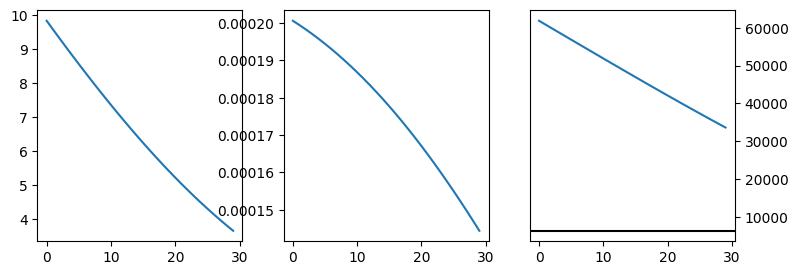

In [422]:
plt.figure(figsize=(9,3))
ax=plt.subplot(131)
ax.plot(history["losses"])
ax=plt.subplot(132)
ax.plot(history["gradients"])
ax=plt.subplot(133)
ax.plot(history["params"])
ax.axhline(omega, color="black")
ax.yaxis.tick_right()

In [ ]:
inputs_cell = [dt,  [gamma, omega, n, eta, kappa, b], 10*omega]

x = load_data(itraj=1, what="hidden_state.npy")
dy = load_data(itraj=1,what="dys.npy")

dev = torch.device("cpu")
rrn = RecurrentNetwork(inputs_cell)


optimizer = torch.optim.SGD(list(rrn.parameters()), lr=1e2)

dys = torch.tensor(data=dy, dtype=torch.float32).to(torch.device("cpu"))

history = {}
history["losses"] = []
history["params"] = []
history["gradients"] = []

for ind in tqdm(range(30)):
    xs_hat, dys_hat = rrn(dys)
    loss = log_lik(dys, dys_hat)
    loss.backward()
    optimizer.step()
    history["losses"].append(loss.item())
    history["params"].append(rrn.RCell.omega_p.detach().numpy()[0])
    history["gradients"].append(rrn.RCell.omega_p.grad.numpy())
    
    optimizer.zero_grad()

 93%|████████████████████████████████████████████████████████████████████████████████████████████████▏      | 28/30 [01:07<00:04,  2.29s/it]

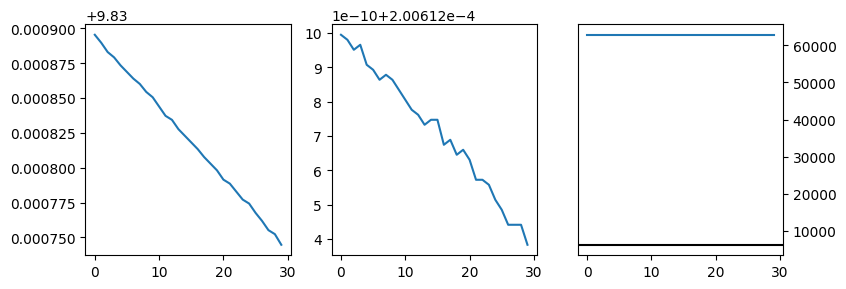

In [414]:
plt.figure(figsize=(9,3))
ax=plt.subplot(131)
ax.plot(history["losses"])
ax=plt.subplot(132)
ax.plot(history["gradients"])
ax=plt.subplot(133)
ax.plot(history["params"])
ax.axhline(omega, color="black")
ax.yaxis.tick_right()

In [155]:
history["params"]

[array([188495.52], dtype=float32),
 array([188495.52], dtype=float32),
 array([188495.52], dtype=float32)]

In [224]:
history["losses"]

[2739.5009765625, 2739.61669921875, 2739.026611328125]

In [648]:
RNN.zero_grad()
optimizer.zero_grad()

In [650]:
RNN.RCell.zero_grad()

In [274]:
class CustomModel(torch.nn.Module):
    def __init__(self,w0):
        super(CustomModel, self).__init__()
        self.w = torch.nn.Parameter(data = torch.tensor([w0], dtype=torch.float32, requires_grad=True))
        
        #self.matrix = torch.tensor(data = [[self.w, -1.],[-self.w, -1.]], dtype=torch.float32, requires_grad=True    This computes \partial_matrix(COST)
        self.matrix_trainable = self.w*torch.tensor(data=[[0,1],[-1,0]], dtype=torch.float32,requires_grad=False)
        self.matrix = self.matrix_trainable - torch.eye(2)
        
    def forward(self, x):
        return self.matrix.matmul(x)
    
def loss(pred,y):
    return torch.mean((pred- y)**2)


my_model = CustomModel(w0=0.01)
optimizer = torch.optim.Adam(lr=0.01, params=my_model.parameters())

device = torch.device("cpu")
x = torch.ones(2).to(device)
y = torch.tensor(data=[2.,0.], dtype=torch.float32).to(device)


for k in range(10):

    optimizer.zero_grad()
    my_model.zero_grad()
    pred = my_model(x)
    cost = loss(pred,y)
    cost.backward()
    optimizer.step()

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [271]:
my_model.w.grad

tensor([-1.9800])

/tmp/ipykernel_8095/2094205978.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:486.)
  my_model.matrix.grad


In [263]:
torch.__version__

'2.0.1+cu117'

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [221]:
dev = torch.device("cpu")


[Parameter containing:
 tensor([0.0100], requires_grad=True)]

In [220]:
loss(x,y)


AttributeError: 'function' object has no attribute 'backward'

In [214]:
class CustomModel(torch.nn.Module):
    def __init__(self,w0):
        super(CustomModel, self).__init__()
        self.w = torch.nn.Parameter(data = torch.tensor([w0], dtype=torch.float32, requires_grad=True))
            
            
    def forward(self, dy, x):
        """
        input_data is dy
        hidden_state is x
        output dy_hat
        """
       # dx = torch.matmul(torch.tensor(data = [[0,1],[-1,0]], dtype=torch.float32)*self.omega_p
        #                  + torch.tensor(data = -0.5*gamma*np.eye(2), dtype=torch.float32)- self.xicovC,x)*dt + torch.matmul(self.xicov,dy)
        # That works!
      #  dx = #self.A_symp.matmul(x)*dt#- self.xicovC).matmul(x)*dt + torch.matmul(self.xicov,dy)
       # dx = self.A_body.matmul(x)*dt
        #ss = torch.tensor(data = [[0,1],[-1,0]], dtype=torch.float32, requires_grad=True)
        #A = ss*self.omega_p + self.A_diag
        dx = self.omega_p*(AA-xicov.matmul(x)*dt 
        dy_hat = self.C.matmul(x)*self.dt
        return torch.stack([x + dx, dy_hat])

class RecurrentNetwork(torch.nn.Module):
    def __init__(self,inputs_cell):
        super(RecurrentNetwork, self).__init__()
        self.RCell = RecurrentCell(inputs_cell=inputs_cell)

    def forward(self, dys):
        dys_hat = []
        xs_hat = [torch.tensor([0., 0.],dtype=torch.float32)]
        x_hat = xs_hat[0]
        for dy_t in dys:
            x_hat, dy_hat = self.RCell(dy_t, x_hat)
            dys_hat += [dy_hat]
            xs_hat += [x_hat]
        return torch.stack(xs_hat), torch.stack(dys_hat)

SyntaxError: '(' was never closed (3996344217.py, line 20)

In [651]:
xs_hat, dys_hat = RNN(dys)
loss = log_lik(dys, dys_hat)
loss.backward()
optimizer.step()


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [ ]:
torch.

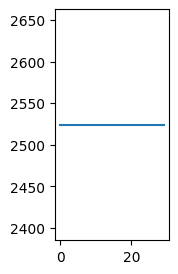

In [635]:
plt.figure(figsize=(5,3))
ax=plt.subplot(131)
ax.plot(history["losses"])

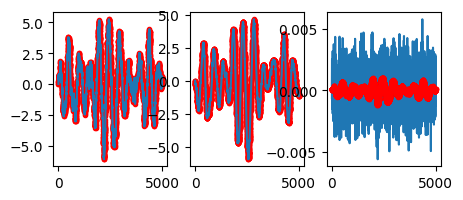

In [421]:
plt.figure(figsize=(5,2))
ax=plt.subplot(131)
ax.plot(xs_hat.detach().numpy()[:,0], color="red",marker='.')
ax.plot(x[:,0])
ax=plt.subplot(132)
ax.plot(xs_hat.detach().numpy()[:,1], color="red",marker='.')
ax.plot(x[:,1])
ax=plt.subplot(133)
ax.plot(dys[:,0])
ax.plot(dys_hat.detach().numpy()[:,0], color="red",marker='.')

In [422]:

def log_lik(dys, dys_hat):
    return torch.sum((dys-dys_hat)**2)/(2*dt)

In [423]:
dev = torch.device("cpu")
optimizer = torch.optim.Adam(lr=0.01, params=rrn.parameters())

In [445]:
Recurrent = RecurrentNetwork(inputs_cell)

In [446]:
dys = torch.tensor(data=dy, dtype=torch.float32).to(dev)#.detach().requires_grad_(True)

In [447]:
xs_hat, dys_hat = Recurrent(dys)
#xs_hat, dys_hat = rrn(dys)

In [448]:
Recurrent.RCell.omega_p.is_leaf

True

In [449]:
rrn.zero_grad()
optimizer.zero_grad()

In [450]:
cost = log_lik(dys,dys_hat)
#cost.detach().requires_grad_(True)

In [451]:
cost.backward()

In [441]:
rrn.RCell.omega_p.detach().requires_grad_(True)

tensor([6283.1855], requires_grad=True)

In [385]:
rrn.RCell.omega_p.grad

In [49]:
class RecurrentCell(torch.nn.Module):
    def __init__(self, dt=0.001):
        super(RecurrentCell, self).__init__()
        self.params = torch.nn.Parameter(data = torch.tensor([11, 8/3, 28],dtype=torch.float32, requires_grad=True))
        self.dt = dt

    def forward(self, input_data, hidden_state):
        sigma, beta, rho = self.params
        x,y,z = hidden_state
        dx, dy, dz = sigma*(y-x), x*(rho-z) -y, x*y - beta*z
        return torch.stack([x+dx*self.dt, y+dy*self.dt, z+dz*self.dt])

class RecurrentNetwork(nn.Module):
    def __init__(self,dt=0.001):
        super(RecurrentNetwork, self).__init__()
        self.RCell = RecurrentCell(dt=dt)

    def forward(self, input):
        outputs = []
        h_t = torch.tensor([-8,7,27],dtype=torch.float32)
        for i, input_t in enumerate(input):
            h_t = self.RCell(None, h_t)
            outputs += [h_t]
        
        outputs = torch.stack(outputs)
        return outputs

In [68]:
Rnn = RecurrentNetwork()
times = torch.arange(0,100,0.001)
outs = Rnn(times)

In [69]:
optimizer = torch.optim.SGD(Rnn.parameters(), lr=0.01)

def MSE(output, target):
    loss = torch.mean((output - target)**2)
    return loss

In [70]:
target_traj  = np.load("data/lorenz/0_1_0.001.npy")
target = torch.tensor(target_traj,dtype=torch.float32).reshape([1000,3])
Rnn.train()

RecurrentNetwork(
  (RCell): RecurrentCell()
)

In [71]:
X = torch.tensor(times).to("cpu")
Y = target.to("cpu")
history = {}
history["losses"] = []
history["params"] = []
history["gradients"] = []

for ind in tqdm(range(30)):
        
    pred = Rnn(X)
    loss = MSE(pred, Y)
    loss.backward()
    optimizer.step()
    
    history["losses"].append(loss.item())
    history["params"].append(list(Rnn.parameters())[0].detach().numpy())
    history["gradients"].append(Rnn.RCell.params.grad.numpy())

    optimizer.zero_grad()


/tmp/ipykernel_2711/2538995262.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(times).to("cpu")
100%|██████████| 30/30 [00:18<00:00,  1.65it/s]


In [73]:
pred = Rnn(X)
loss = MSE(pred, Y)
loss.backward()

tensor([ 1.1262, -2.3285,  5.9817])

Text(0.5, 0.92, 'Lorenz Attractor')

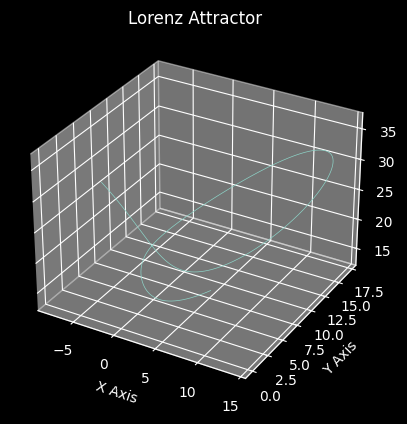

In [34]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(*outs.detach().numpy().T,lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")

tensor([[-7.8500,  7.1877, 26.1880],
        [-7.6996,  7.3651, 25.3983],
        [-7.5490,  7.5328, 24.6304],
        ...,
        [ 6.8314,  6.8313,  1.6667],
        [ 6.8314,  6.8313,  1.6667],
        [ 6.8314,  6.8313,  1.6667]], grad_fn=<StackBackward0>)

In [ ]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Train the network

for epoch in range(epochs):
    for batch, (data, target) in enumerate(train_loader):
        # Obtaining the cuda parameters
        data = data.to(device=device)
        target = target.to(device=device)

        # Reshaping to suit our model
        data = data.reshape(data.shape[0], -1)

        # Forward propagation
        score = model(data)
        loss = criterion(score, target)

        # Backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [2]:
@jit(nopython=True)
def f(x,t,sigma=10, beta=8/3,rho=28):
    X,Y,Z = x
    return np.array([sigma*(Y-X), X*(rho-Z)-Y, X*Y - (beta*Z)])
@jit(nopython=True)aaaaa
def g(x,t):
    return np.zeros(3)

In [3]:
dt = 0.001
times = np.arange(0,100,dt)
x0=np.array([-8,7,27])
xx1 = integrate(f,g,x0,times,dt,mode="euler")
xx2 = integrate(f,g,x0,times,dt,mode="RK4")

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

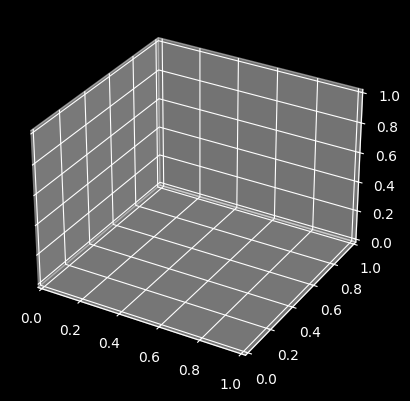

In [9]:
import os 

os.makedirs("data/trajs/lorenz/",exist_ok=True)
np.save("data/trajs/lorenz/1",xx1)